## Theory:

##### Implicit data *(the type of data we’re using here)*

Implicitdata we gather from the users behaviour, with no ratings or specific actions needed. It could be what items a user purchased, how many times they played a song or watched a movie, how long they’ve spent reading a specific article etc. The upside is that we have a lot more of this data, the downside is that it’s more noisy and not always apparent what it means.


#### Matrix Factorization

The idea is basically to take a large (or potentially huge) matrix and factor it into some smaller representation of the original matrix. We end up with two or more lower dimensional matrices whose product equals the original one.

we use matrix factorization to mathematically reduce the dimensionality of our **original “all users by all items” **matrix into something much smaller that represents **“all papers by some marks dimensions” and “all students by some marks dimensions”**. These dimensions are called ***latent or hidden features*** and we learn them from our data.

Doing this reduction and working with fewer dimensions makes it both much more computationally efficient and but also gives us better results since we can reason about items in this more compact “marks space”

***If we can express each user as a vector of their marks values, and at the same time express each item as a vector of what tastes they represent, we can quite easily make a recommendation.***

This also gives us the ability to find connections between users who have no specific items in common but share common tastes.



##### **Matrix Factorization with Implicit Data:**

#### Alternating Least Squares

ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.

We have our original matrix R of size u x i with our users, items and some type of feedback data. We then want to find a way to turn that into one matrix with users and hidden features of size u x f and one with items and hidden features of size f x i. In U and V we have weights for how each user/item relates to each feature. What we do is we calculate U and V so that their product approximates R as closely as possible: R ≈ U x V.

By randomly assigning the values in U and V and using least squares iteratively we can arrive at what weights yield the best approximation of R. The least squares approach in it’s basic forms means fitting some line to the data, measuring the sum of squared distances from all points to the line and trying to get an optimal fit by minimising this value.

With the alternating least squares approach we use the same idea but iteratively alternate between optimizing U and fixing V and vice versa. We do this for each iteration to arrive closer to R = U x V.

Their solution is to merge the preference (p) for an item with the confidence (c) we have for that preference. We start out with missing values as a negative preference with a low confidence value and existing values a positive preference but with a high confidence value. We can use something like play count, time spent on a page or some other form of interaction as the basis for calculating our confidence.
Paper [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)


##### Preference:
p(ui) = {1 => r(ui)>0
         0 => r(ui)=0
        }

Preference is a binary representation of feedback data r. 

###### Confidence:
c(ui) = 1 + αr(ui)

confidence is calculated using the magnitude of r (the feedback data) giving us a larger confidence the more times a user has played, viewed or clicked an item. The rate of which our confidence increases is set through a linear scaling factor α. We also add 1 so we have a minimal confidence even if α x r equals zero.

This also means that even if we only have one interaction between a user and item the confidence will be higher than that of the unknown data given the α value. α can be selected by us. (paper suggests 40 works).

The goal now is to find the vector for each user (xu) and item (yi) in feature dimensions which means we want to minimize the following loss function:

##### Loss Function:
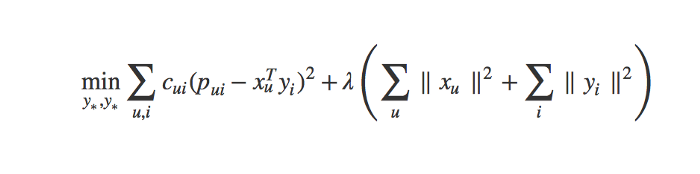

As the paper notes, if we fix the user factors or item factors we can calculate a global minimum. The derivative of the above equation gets us the following equation for minimizing the loss of our users:

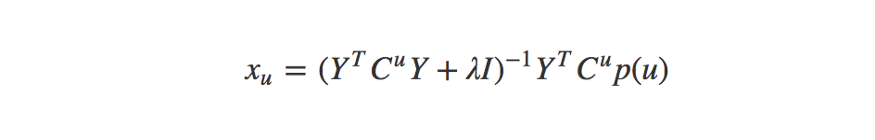

And the this for minimizing it for our items:

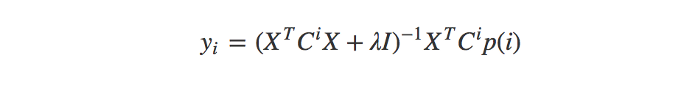

One more step is that by realizing that the product of Y-transpose, Cu and Y can be broken out as shown below:

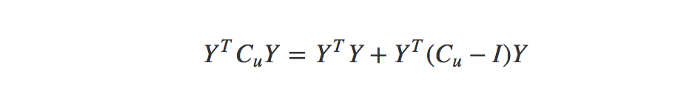

Now we have Y-transpose-Y and X-transpose-X independent of u and i which means we can precompute it and make the calculation much less intensive. So with that in mind our final user and item equations are:

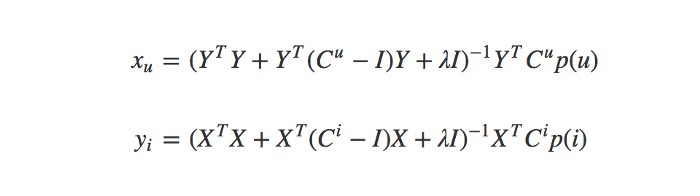

1.   X and Y: Our randomly initialized user and item matricies. These will get alternatingly updated.

2.   Cu and Ci: Our confidence values.
3.   λ: Regularizer to reduce overfitting (we’re using 0.1).
4.   p(u) and p(i): The binary preference for an item. One if we know the preference and zero if we don’t.
5.   I (eye): The identity matrix. Square matrix with ones on the diagonal and zeros everywhere else.

By iterating between computing the two equations above we arrive at one matrix with user vectors and one with item vectors that we can then use to produce recommendations or find similarities.







## Code

### Getting Data from the user: 

Current Dataset: [Student_performance_parameters_final_without_result.xlsx](https://docs.google.com/spreadsheets/d/1Vl-VpRlwDlaAdgnK8f9dqXYAUGUE9jfz/edit?usp=sharing&ouid=108334363958270871098&rtpof=true&sd=true)

In [ ]:
#@title Upload Historical Data:

#@markdown ---

from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]

Saving Student_performance_parameters_final_without_rating.xlsx to Student_performance_parameters_final_without_rating.xlsx


In [ ]:
#@title Select the Semester and Paper(s): { run: "auto" }

#@markdown ### Select Semester:

Semester = 'Sem_6' #@param ["Sem_1", "Sem_2", "Sem_3", "Sem_4", "Sem_5", "Sem_6", "Sem_7", "Sem_8"]
key = Semester

known_solution = []

#@markdown ### Select Paper:
Paper_1 = False #@param {type:"boolean"}
Paper_2 = False #@param {type:"boolean"}
Paper_3 = True #@param {type:"boolean"}
Paper_4 = True #@param {type:"boolean"}
Paper_5 = False #@param {type:"boolean"}
Paper_6 = False #@param {type:"boolean"}
Paper_7 = False #@param {type:"boolean"}

if Paper_1:
    known_solution.append('Paper 1')

if Paper_2:
    known_solution.append('Paper 2')

if Paper_3:
    known_solution.append('Paper 3')

if Paper_4:
    known_solution.append('Paper 4')

if Paper_5:
    known_solution.append('Paper 5')

if Paper_6:
    known_solution.append('Paper 6')

if Paper_7:
    known_solution.append('Paper 7')

#@markdown ### Enter Minimum Rating:

min_rating = 60 #@param {type:"slider", min:0, max:100, step:1}

#@markdown ### Number of Top Recommendations For Calculation:

Number_of_top_recommendations = 4 #@param {type:"slider", min:2, max:7, step:1}


#### Rating for the subjects already chosen:

In [ ]:
#@title Select Parameters to consider: { run: "auto" }

#@markdown ---

Subject_Content = True #@param {type:"boolean"}
Teacher_Rating = False #@param {type:"boolean"}
Subject_Interest = True #@param {type:"boolean"}
Practical_Knowledge = True #@param {type:"boolean"}
Likely_to_recommend = True #@param {type:"boolean"}



In [ ]:
parameters = [] #matches headers

if Subject_Content:
  parameters.append("subject_content")

if Teacher_Rating:
  parameters.append("teacher_rating")

if Subject_Interest:
  parameters.append("subject_interest")

if Practical_Knowledge:
  parameters.append("practical_knowledge")

if Likely_to_recommend:
  parameters.append("likely_to_recommend")

In [ ]:
parameters

['subject_content',
 'subject_interest',
 'practical_knowledge',
 'likely_to_recommend']

In [ ]:
#@title Select Rating for the chosen subject (out of 20): { run: "auto" }

dict_append_list = []

for paper in known_solution:
  print("Subject:", paper)
  dict_append = {'Student_ID': 'NEW_VALUE', 'Paper_Name': paper, 'Rating': 0}

  rating = 0
  i = 0
  while (i < len(parameters)):
    try:
      val = int(input("  Enter Rating for " + parameters[i] + ":"))
      rating += val
    
      if val < 0 or val > 20:
        print("Invalid Input: Enter a rating between 1-20")
        i -= 1

      i += 1
    except:
      20
      print("Invalid Input")
  
  dict_append['Rating'] = rating

  dict_append_list.append(dict_append)


Subject: Paper 3
  Enter Rating for subject_content:20
  Enter Rating for subject_interest:17
  Enter Rating for practical_knowledge:14
  Enter Rating for likely_to_recommend:12
Subject: Paper 4
  Enter Rating for subject_content:45
Invalid Input: Enter a rating between 1-20
  Enter Rating for subject_content:-1
Invalid Input: Enter a rating between 1-20
  Enter Rating for subject_content:4.6
Invalid Input
  Enter Rating for subject_content:14
  Enter Rating for subject_interest:16
  Enter Rating for practical_knowledge:20
  Enter Rating for likely_to_recommend:18


In [ ]:
dict_append_list

[{'Paper_Name': 'Paper 3', 'Rating': 63, 'Student_ID': 'NEW_VALUE'},
 {'Paper_Name': 'Paper 4', 'Rating': 112, 'Student_ID': 'NEW_VALUE'}]

### Importing Libraries


In [ ]:
import random
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

### Preparing the Data

In [ ]:
### Input and get the semester:
df = pd.read_excel(file_name, sheet_name='Sheet1')

df_dict_sem = {}
for name in df['Semster_Name'].unique():
    df_dict_sem[name] = df[df['Semster_Name'] == name].reset_index(drop=True)

df_sem = df_dict_sem[key]

In [ ]:
#Computing Rating for all
df_sem["Rating"] = 0
for parameter in parameters:
  df_sem["Rating"] += df_sem[parameter] 

In [ ]:
#Applying Rating Threshold
df_sem_min_rating = df_sem[df_sem['Rating'] > min_rating].reset_index(drop=True)
df_sem_min_rating.head()

,Unnamed: 0,Student_ID,Semster_Name,Paper_ID,Paper_Name,subject_content,teacher_rating,subject_interest,practical_knowledge,likely_to_recommend,Rating
0,34,SID20131143,Sem_6,SEMI0068923,Paper 1,19,20,19,19,16,73
1,35,SID20131143,Sem_6,SEMI0067259,Paper 2,13,15,19,18,19,69
2,37,SID20131143,Sem_6,SEMI0064181,Paper 4,16,15,17,13,15,61
3,89,SID20131151,Sem_6,SEMI0068923,Paper 1,19,10,15,14,14,62
4,91,SID20131151,Sem_6,SEMI0065623,Paper 3,15,18,19,19,16,69


In [ ]:
df_sem_min_rating = df_sem_min_rating[['Student_ID', 'Paper_Name', 'Rating']]
df_sem_min_rating.head()

,Student_ID,Paper_Name,Rating
0,SID20131143,Paper 1,73
1,SID20131143,Paper 2,69
2,SID20131143,Paper 4,61
3,SID20131151,Paper 1,62
4,SID20131151,Paper 3,69


### Data Prepocessing

In [ ]:
#Drop rows with missing values
data = df_sem_min_rating.dropna()

In [ ]:
for dict_append in dict_append_list:
  data = data.append(dict_append, ignore_index = True)
data.tail()

,Student_ID,Paper_Name,Rating
10610,SID20189989,Paper 5,78
10611,SID20189989,Paper 6,71
10612,SID20189989,Paper 7,75
10613,NEW_VALUE,Paper 3,63
10614,NEW_VALUE,Paper 4,112


In [ ]:
#put names into numerical IDs
data['student_cat_id'] = data['Student_ID'].astype("category").cat.codes
data['paper_cat_id'] = data['Paper_Name'].astype("category").cat.codes
data.head()

,Student_ID,Paper_Name,Rating,student_cat_id,paper_cat_id
0,SID20131143,Paper 1,73,1,0
1,SID20131143,Paper 2,69,1,1
2,SID20131143,Paper 4,61,1,3
3,SID20131151,Paper 1,62,2,0
4,SID20131151,Paper 3,69,2,2


In [ ]:
#Lookup frame to get student id back in readable form later
student_lookup = data[['student_cat_id', 'Student_ID']].drop_duplicates()
student_lookup['student_cat_id'] = student_lookup.student_cat_id.astype(str)
student_lookup.head()

,student_cat_id,Student_ID
0,1,SID20131143
3,2,SID20131151
7,3,SID20131171
8,4,SID20131176
12,5,SID20131177


In [ ]:
student_lookup.tail()

,student_cat_id,Student_ID
10602,3702,SID20189926
10605,3703,SID20189949
10607,3704,SID20189982
10610,3705,SID20189989
10613,0,NEW_VALUE


In [ ]:
#Lookup frame to get paper names back in readable form later
item_lookup = data[['paper_cat_id', 'Paper_Name']].drop_duplicates()
item_lookup['paper_cat_id'] = item_lookup.paper_cat_id.astype(str)
item_lookup.head()

,paper_cat_id,Paper_Name
0,0,Paper 1
1,1,Paper 2
2,3,Paper 4
4,2,Paper 3
6,5,Paper 6


In [ ]:
#Dropping Student_ID and Paper_Name 
data = data.drop(['Student_ID', 'Paper_Name'], axis=1)
data.head()

,Rating,student_cat_id,paper_cat_id
0,73,1,0
1,69,1,1
2,61,1,3
3,62,2,0
4,69,2,2


### Creating the Sparse Matrix

In [ ]:
# Lists of all student, papers and rating
students = list(np.sort(data.student_cat_id	.unique()))
papers = list(np.sort(data.paper_cat_id.unique()))
rating = list(data.Rating)

In [ ]:
# rows and columns for the matrix, students vs papers
rows = data.student_cat_id.astype(int)
cols = data.paper_cat_id.astype(int)

In [ ]:
#sparse matrix for students vs papers and values with rating
data_sparse = sparse.csr_matrix((rating, (rows,cols)), shape=(len(students), len(papers)))
data_sparse

<3706x7 sparse matrix of type '<class 'numpy.longlong'>'
	with 10615 stored elements in Compressed Sparse Row format>

### Implementing ALS With implicit data and training:

In [ ]:
def nonzeros(m, row):
  for index in range(m.indptr[row], m.indptr[row+1]):
    yield m.indices[index], m.data[index]
      
      
def implicit_als_cg(Cui, features=20, iterations=20, lambda_val=0.1):
  students_size, papers_size = Cui.shape

  X = np.random.rand(students_size, features) * 0.01
  Y = np.random.rand(papers_size, features) * 0.01

  Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()

  for iteration in range(iterations):
    print('iteration {0} of {1}'.format(iteration+1, iterations))
    least_squares_cg(Cui, X, Y, lambda_val)
    least_squares_cg(Ciu, Y, X, lambda_val)
    
  return sparse.csr_matrix(X), sparse.csr_matrix(Y)
  
  
def least_squares_cg(Cui, X, Y, lambda_val, cg_steps=3):
  students, features = X.shape
  
  YtY = Y.T.dot(Y) + lambda_val * np.eye(features)

  for u in range(students):
    x = X[u]
    r = -YtY.dot(x)

    for i, confidence in nonzeros(Cui, u):
      r += (confidence - (confidence - 1) * Y[i].dot(x)) * Y[i]

    p = r.copy()
    rsold = r.dot(r)

    for it in range(cg_steps):
      Ap = YtY.dot(p)
      for i, confidence in nonzeros(Cui, u):
          Ap += (confidence - 1) * Y[i].dot(p) * Y[i]

      alpha = rsold / p.dot(Ap)
      x += alpha * p
      r -= alpha * Ap

      rsnew = r.dot(r)
      p = r + (rsnew / rsold) * p
      rsold = rsnew

    X[u] = x

In [ ]:
alpha_val = 15
conf_data = (data_sparse * alpha_val).astype('double')
user_vecs, item_vecs = implicit_als_cg(conf_data, iterations=20, features=20)

iteration 1 of 20
iteration 2 of 20
iteration 3 of 20
iteration 4 of 20
iteration 5 of 20
iteration 6 of 20
iteration 7 of 20
iteration 8 of 20
iteration 9 of 20
iteration 10 of 20
iteration 11 of 20
iteration 12 of 20
iteration 13 of 20
iteration 14 of 20
iteration 15 of 20
iteration 16 of 20
iteration 17 of 20
iteration 18 of 20
iteration 19 of 20
iteration 20 of 20


In [ ]:
user_vecs

<3706x20 sparse matrix of type '<class 'numpy.float64'>'
	with 74120 stored elements in Compressed Sparse Row format>

In [ ]:
item_vecs

<7x20 sparse matrix of type '<class 'numpy.float64'>'
	with 140 stored elements in Compressed Sparse Row format>

### Recommendations for a Student:

In [ ]:
student_id = int(student_lookup[student_lookup['Student_ID'] == 'NEW_VALUE'].iloc[0].student_cat_id)

In [ ]:
# Let's print out what the student has selected to
consumed_idx = data_sparse[student_id,:].nonzero()[1].astype(str)
consumed_items = item_lookup.loc[item_lookup.paper_cat_id.isin(consumed_idx)]
print(consumed_items)

  paper_cat_id Paper_Name
2            3    Paper 4
4            2    Paper 3


In [ ]:
def recommend(student_id, data_sparse, user_vecs, item_vecs, item_lookup, num_items=Number_of_top_recommendations):
  # Get all interactions by the user
  user_interactions = data_sparse[student_id,:].toarray()

  # We don't want to recommend items the user has consumed. So let's set them all to 0 and the unknowns to 1.
  user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
  user_interactions[user_interactions > 1] = 0

  # This is where we calculate the recommendation by taking the dot-product of the user vectors with the item vectors.
  rec_vector = user_vecs[student_id,:].dot(item_vecs.T).toarray()

  # Let's scale our scores between 0 and 1 to make it all easier to interpret.
  min_max = MinMaxScaler()
  rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
  recommend_vector = user_interactions*rec_vector_scaled

  # Get all the Paper_Name indices in order of recommendations (descending) and select only the top "num_items" items. 
  item_idx = np.argsort(recommend_vector)[::-1][:num_items]

  papers_lst = []
  paper_scores_lst = []

  for idx in item_idx:
    papers_lst.append(item_lookup.Paper_Name.loc[item_lookup.paper_cat_id == str(idx)].iloc[0])
    paper_scores_lst.append(recommend_vector[idx])
  
  recommendations = pd.DataFrame({'paper': papers_lst, 'score': paper_scores_lst})

  return recommendations

In [ ]:
recommendations = recommend(student_id, data_sparse, user_vecs, item_vecs, item_lookup)
print(recommendations)

     paper     score
0  Paper 5  0.070387
1  Paper 2  0.063142
2  Paper 6  0.017485
3  Paper 7  0.002668


The above recommendations show us which papers the students should choose.